<a href="https://colab.research.google.com/github/Uzmamushtaque/Projects-in-Machine-Learning-and-AI/blob/main/GAN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GAN Training
A GAN comprises of a discriminator and a generator. The discriminator classifies data (reduction) and a generator generates (expands) data.
A generative adversarial network (GAN) has two neural networks, a generator and a discriminator, set to compete against each other as adversaries. The discriminator is trained to classify data from a training set as real, and data from the generator as fake. The generator is trained to create data that looks real enough to fool the discriminator.

The standard GAN training loop has three steps:

1. Train the discriminator with a real data example.
2. Train the discriminator with a generated data example.
3. Train the generator to get a correct classification from the discriminator.

As an example we create a pattern 1010 via a GAN.

In [1]:
import torch
import torch.nn as nn
import pandas as pd

In [2]:
def generate_real():
    real_data = torch.FloatTensor([1, 0, 1, 0])
    return real_data

print("Real data:", generate_real())

Real data: tensor([1., 0., 1., 0.])


Creating real data with some randomness.

In [3]:
import random

def generate_real():
    real_data = torch.FloatTensor(
    [random.uniform(0.8, 1.0),
    random.uniform(0.0, 0.2),
    random.uniform(0.8, 1.0),
    random.uniform(0.0, 0.2)])
    return real_data

print("Real random value:", generate_real())

Real random value: tensor([0.9683, 0.0646, 0.8512, 0.1885])


### The Discriminator Class


In [4]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    #Create model
    self.model = nn.Sequential(
        nn.Linear(4,3),
        nn.Sigmoid(),
        nn.Linear(3,1),
        nn.Sigmoid()
    )
    # create loss function
    self.loss_function = nn.MSELoss()

    # create optimiser, using stochastic gradient descent
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # counter and accumulator for progress
    self.counter = 0
    self.progress = []

  def forward(self,inputs):
    return self.model(inputs)

  def train(self,inputs,targets):
    # calculate the output of the network
    outputs = self.forward(inputs)

    # calculate loss
    loss = self.loss_function(outputs, targets)

    # increase counter and accumulate error every 10 epochs
    self.counter += 1
    if (self.counter % 10 == 0):
        self.progress.append(loss.item())
    if (self.counter % 10000 == 0):
        print("counter = ", self.counter)
        pass

    # zero gradients, perform a backward pass, update weights
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


It is a good idea to test the discriminator first before coupling it with the generator. This will tell us that the discriminator has the capacity to at least separate real data from random noise.

In [5]:
def generate_random(size=4):
    random_data = torch.rand(size)
    return random_data

print("Random noise pattern:", generate_random(4))

Random noise pattern: tensor([0.8486, 0.3351, 0.9605, 0.4885])


In [6]:
D = Discriminator()

for i in range(10000):
    # real data
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(), torch.FloatTensor([0.0]))

counter =  10000
counter =  20000


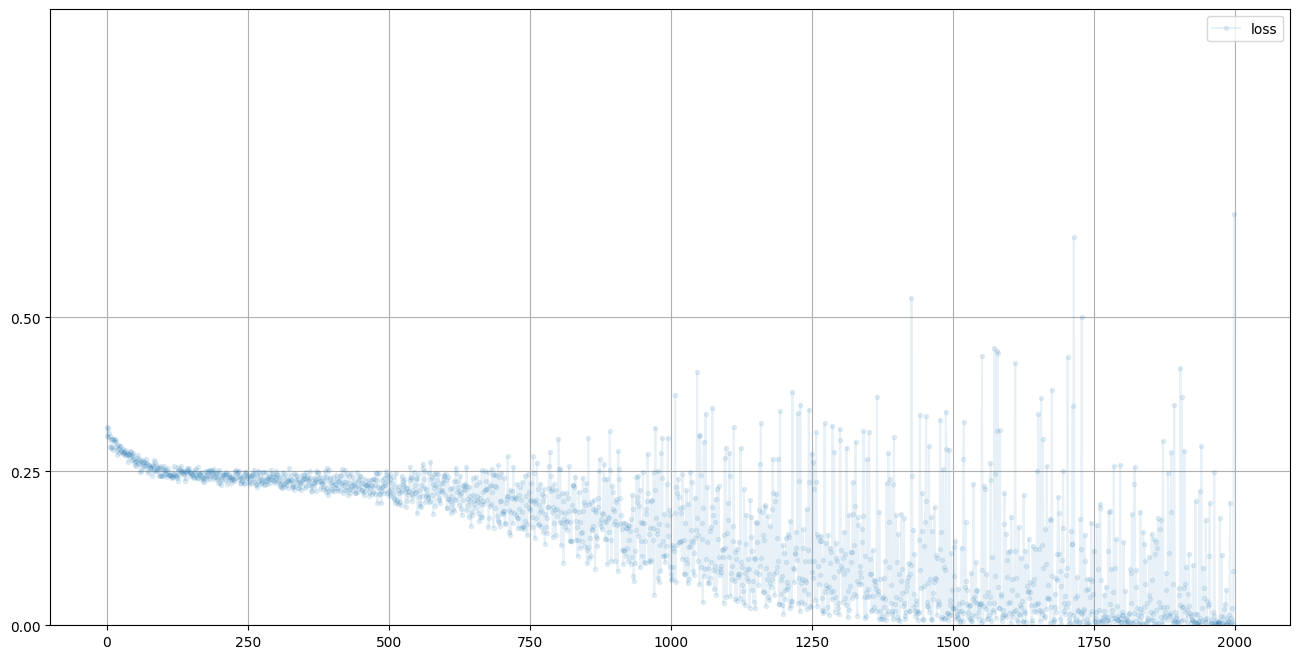

In [7]:
D.plot_progress()

In [8]:
print("Real data source:", D.forward(generate_real()).item())

print("Random noise:", D.forward(generate_random(4)).item())

Real data source: 0.7802181839942932
Random noise: 0.07498886436223984


We are not sure if this configuration would work for the GAN network but it does discriminate between real and fake examples.

In [10]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(1,3),
        nn.Sigmoid(),
        nn.Linear(3,4),
        nn.Sigmoid())
    self.optimizer = torch.optim.SGD(self.parameters(),lr = 0.01)
    self.counter = 0
    self.progress =[]

  def forward(self,inputs):
    return self.model(inputs)

  def train(self,D,inputs,targets):
    g_out = self.forward(inputs)
    d_out = D.forward(g_out)
    loss = D.loss_function(d_out,targets)

    # increase counter and accumulate error every 10
    self.counter += 1
    if (self.counter % 10 == 0):
        self.progress.append(loss.item())
        pass

    # zero gradients, perform a backward pass, update weights
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


Training the generator is different from the discriminator because we do not have a separate Loss function. Generator learns from the backpropagated gradients of the discriminator, therefore the training function of the generator will use the loss of the discriminator.

In [11]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.3651, 0.6036, 0.3937, 0.4786], grad_fn=<SigmoidBackward0>)

The pattern isn’t in the form 1010 because the generator isn’t trained yet.

In [16]:
# create Discriminator and Generator
%%time
D = Discriminator()
G = Generator()

# train Discriminator and Generator
image_list = []
for i in range(10000):

    # train discriminator on true
    D.train(generate_real(), torch.FloatTensor([1.0]))

    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    # add image to list every 1000
    if (i % 1000 == 0):
      image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )
    # train generator
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))




counter =  10000
counter =  20000
CPU times: user 23.1 s, sys: 365 ms, total: 23.5 s
Wall time: 23.7 s


That detach() applied to the output of the generator detaches it from the computation graph. Normally, calling backwards() on the discriminator loss causes error gradients to be calculated all the way back along with the computation graph - from the discriminator loss, through the discriminator itself, and then back through the generator. Because we’re only training the discriminator, we don’t need to calculate the gradients for the generator. That detach() applied to the generator output cuts the computation graph at that point.

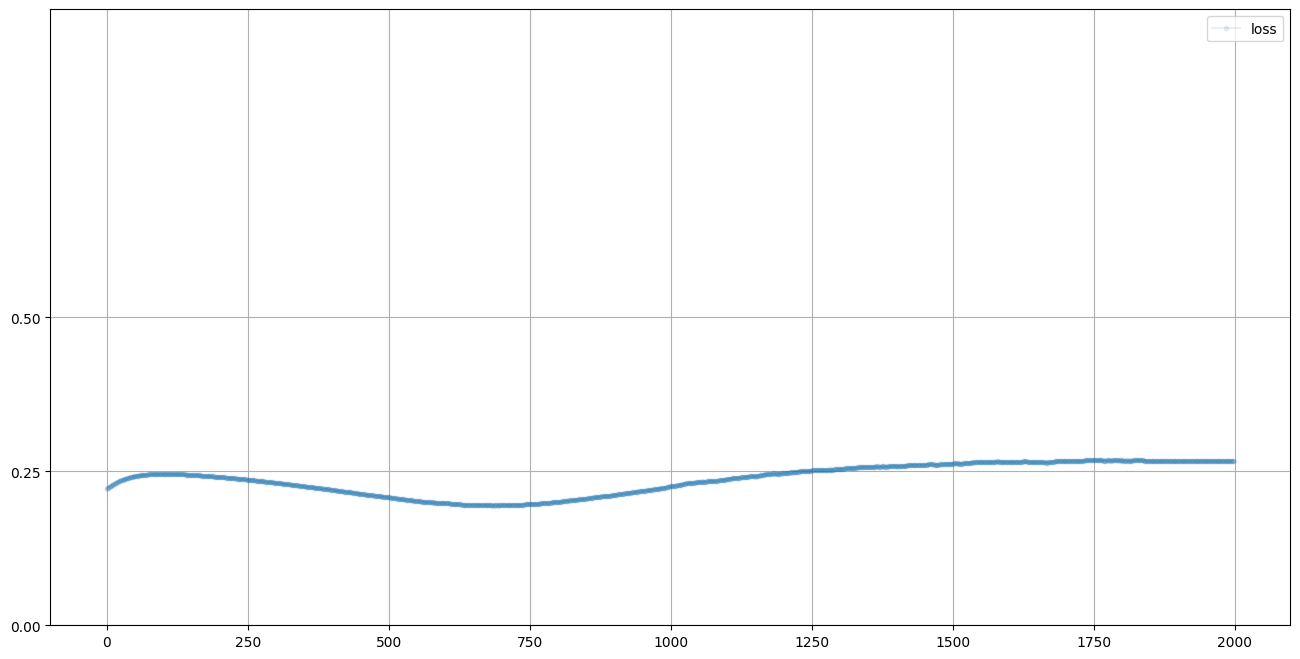

In [17]:
D.plot_progress()

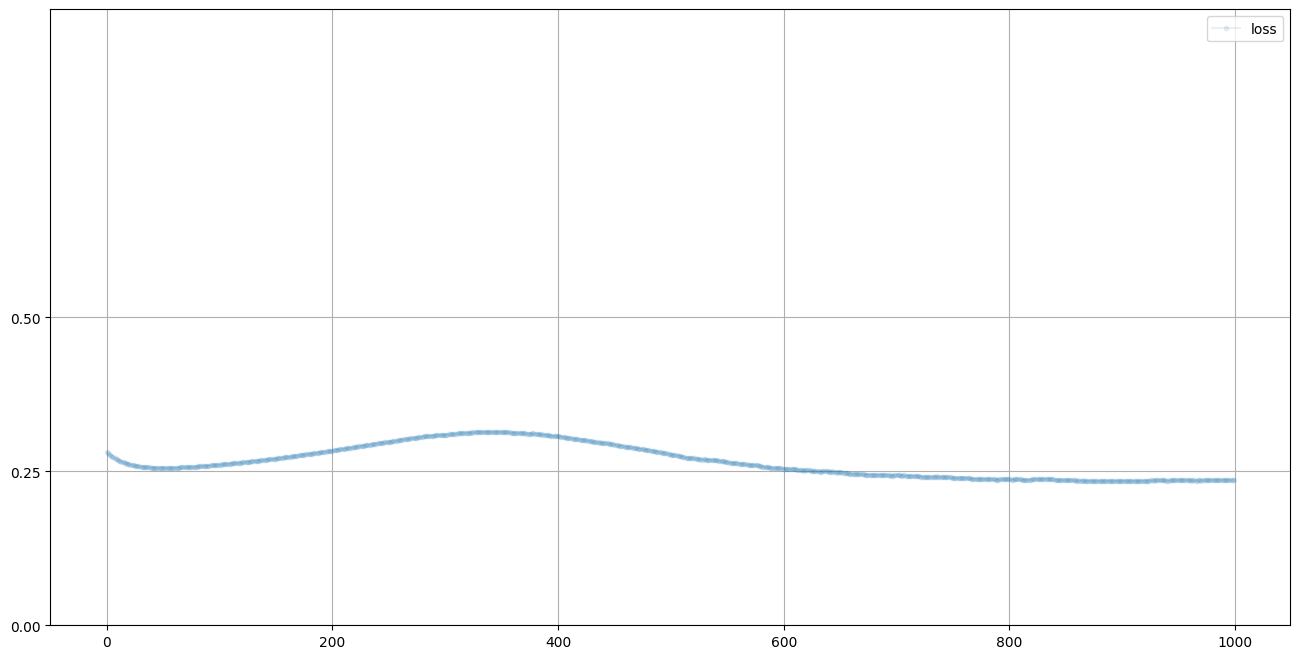

In [18]:
G.plot_progress()

In [19]:
# check the generated output of Generator
G.forward(torch.FloatTensor([0.5]))

tensor([0.9417, 0.0391, 0.9396, 0.0396], grad_fn=<SigmoidBackward0>)

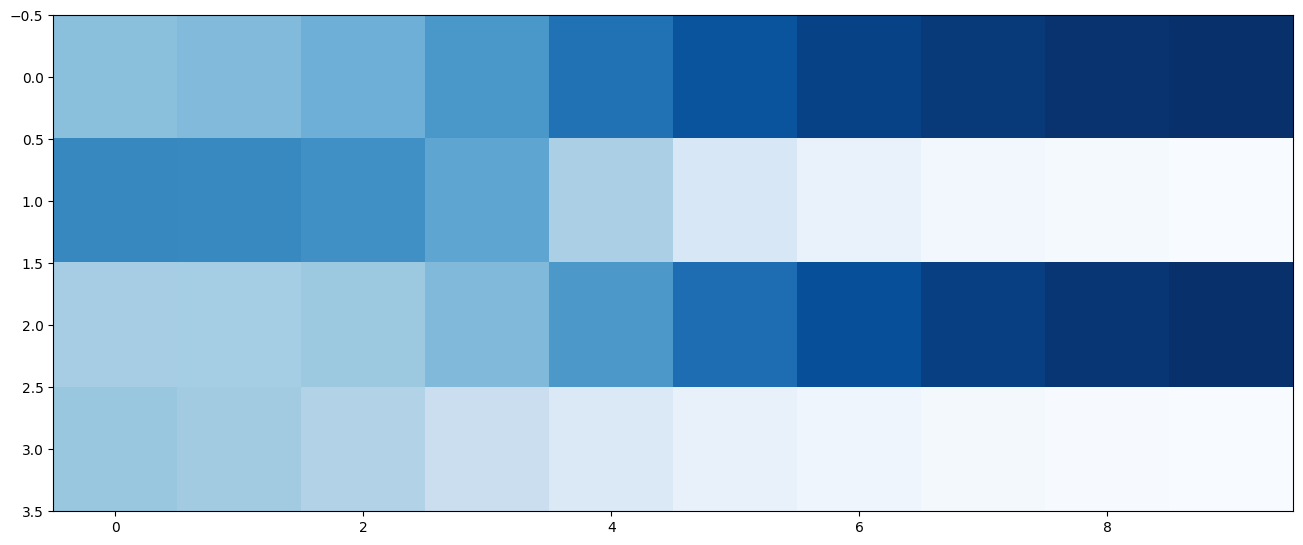

In [20]:
import numpy
import matplotlib.pyplot as plt
plt.figure(figsize = (16,8))
plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')

This chart shows quite clearly how the generator improves over time. Initially the generator creates a rather indistinct pattern (the first column in the output). About half way through training, the generator suddenly is able to generate a 1010 pattern which continues to become clearer during the remainder of the training.

## Conclusion

A good pattern for developing and training a GAN includes the following steps.

1. Preview data from the real dataset.

2. Test the discriminator to see if it can at least learn to separate real data from random noise.

3. Test the untrained generator to see if it can create data of the right shape.

4. Visualize the loss values to understand how well training progressed.